# Open MODIS (hdf4)  Data in Python 

The **MOD**erate-resolution **I**maging **S**pectroradiometer is a sensor that 
produces multispectral data with 500m spatial resolution and 1-2 day temporal 
resolution. MODIS data is the basis for some common data products
including:
  * Burned Area
  * Sea Surface Temperature
  * Aerosol
  * Snow
  * Sea Ice
  
All of these products are available in the hdf4 format.

  
## Learning objectives
  * Introduce hierarchical data formats
  * Import hdf4 MODIS data using rioxarray
  * Query hdf4 metadata to learn about its structure

## Why use hierarchical data formats?

Hierarchical data files are:
  * **Self-Describing**
  * **Store Heterogeneous Data**
  * **Support Data Slicing**
  * **An Open Format**
  
...and of course we want to use HDFs because many organizations recognize 
the advantages and have made useful data available in this format.

### Hierarchical data formats can contain multiple types of data in one file

Think about the files and folders stored on your computer. You might have 
a data directory with some temperature data for multiple field sites. This 
temperature data is collected every minute and summarized on an hourly, 
daily and weekly basis.

Within ONE HDF file, you can store a similar set of data organized in the same 
way that you might organize files and folders on your computer.

![Hierarchical file structure can contain many types of data in one file](https://www.earthdatascience.org/images/earth-analytics/hierarchical-data-formats/hdf5-example-data-structure-with-metadata.jpg)

### hdf4 files can be opened in Python using rioxarray

Similar to opening **.tif** files using rasterio, 
you will use a context manager to open hdf4 files. Because the data are 
hierarchical, you will have to loop through the main dataset and the 
subdatasets nested within the main dataset to access the reflectance 
data (the bands) and the qa layers. 

In [1]:
import os

import earthpy as et
import earthpy.plot as ep
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy.ma as ma
from rasterio._base import get_dataset_driver
from rasterio.plot import plotting_extent
import rioxarray as rxr
from shapely.geometry import box

# Get the MODIS data
et.data.get_data('cold-springs-modis-h4')
# Get the fire boundary
et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

# This will make rioxarray run faster
rioxarray_option = rxr.set_options(export_grid_mapping=False)

In [6]:
# Create a path to the pre-fire MODIS h4 data
modis_pre_path = os.path.join("cold-springs-modis-h4",
                              "07_july_2016",
                              "MOD09GA.A2016189.h09v05.006.2016191073856.hdf")

if not os.path.exists(modis_pre_path):
    raise ValueError('The MODIS path does not exist')

In [7]:
# This returns a list of two objects
modis = rxr.open_rasterio(modis_pre_path,
                          masked=True)


modis

[<xarray.Dataset>
 Dimensions:               (y: 1200, x: 1200, band: 1)
 Coordinates:
   * y                     (y) float64 4.447e+06 4.446e+06 ... 3.336e+06
   * x                     (x) float64 -1.001e+07 -1.001e+07 ... -8.896e+06
   * band                  (band) int64 1
     spatial_ref           int64 0
 Data variables:
     num_observations_1km  (band, y, x) float32 ...
     granule_pnt_1         (band, y, x) float32 ...
     state_1km_1           (band, y, x) float32 ...
     SensorZenith_1        (band, y, x) float32 ...
     SensorAzimuth_1       (band, y, x) float32 ...
     Range_1               (band, y, x) float32 ...
     SolarZenith_1         (band, y, x) float32 ...
     SolarAzimuth_1        (band, y, x) float32 ...
     gflags_1              (band, y, x) float32 ...
     orbit_pnt_1           (band, y, x) float32 ...
 Attributes: (12/136)
     ADDITIONALLAYERS1KM:                 11
     ADDITIONALLAYERS500M:                1
     ASSOCIATEDINSTRUMENTSHORTNAME.1:  

By adding two output variables, open_rasterio will save
the reflectance / band data in a separate object from
the qa (quality assurance) data.

In [8]:
# By adding two output variables,
modis_meta, modis_data = rxr.open_rasterio(
    modis_pre_path, masked=True)

The fist object returned contains all of the qa (quality assurance) 
and metadata layers.


In [9]:
# The first object is a metadata object
modis_meta

<xarray.Dataset>
Dimensions:               (y: 1200, x: 1200, band: 1)
Coordinates:
  * y                     (y) float64 4.447e+06 4.446e+06 ... 3.336e+06
  * x                     (x) float64 -1.001e+07 -1.001e+07 ... -8.896e+06
  * band                  (band) int64 1
    spatial_ref           int64 0
Data variables:
    num_observations_1km  (band, y, x) float32 ...
    granule_pnt_1         (band, y, x) float32 ...
    state_1km_1           (band, y, x) float32 ...
    SensorZenith_1        (band, y, x) float32 ...
    SensorAzimuth_1       (band, y, x) float32 ...
    Range_1               (band, y, x) float32 ...
    SolarZenith_1         (band, y, x) float32 ...
    SolarAzimuth_1        (band, y, x) float32 ...
    gflags_1              (band, y, x) float32 ...
    orbit_pnt_1           (band, y, x) float32 ...
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

In [10]:
# The second contains your spectral data - ie the "bands"
modis_data

<xarray.Dataset>
Dimensions:                (y: 2400, x: 2400, band: 1)
Coordinates:
  * y                      (y) float64 4.448e+06 4.447e+06 ... 3.336e+06
  * x                      (x) float64 -1.001e+07 -1.001e+07 ... -8.896e+06
  * band                   (band) int64 1
    spatial_ref            int64 0
Data variables:
    num_observations_500m  (band, y, x) float32 ...
    sur_refl_b01_1         (band, y, x) float32 ...
    sur_refl_b02_1         (band, y, x) float32 ...
    sur_refl_b03_1         (band, y, x) float32 ...
    sur_refl_b04_1         (band, y, x) float32 ...
    sur_refl_b05_1         (band, y, x) float32 ...
    sur_refl_b06_1         (band, y, x) float32 ...
    sur_refl_b07_1         (band, y, x) float32 ...
    QC_500m_1              (band, y, x) float64 ...
    obscov_500m_1          (band, y, x) float32 ...
    iobs_res_1             (band, y, x) float32 ...
    q_scan_1               (band, y, x) float32 ...
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

### Hierarchical data formats are self-describing

#### You can view metadata before opening the file in Python
The command below runs `gdalinfo` which allows you to view the metadata.
Calling a command using  `!` in  notebooks runs a bash command!

NOTE - this will ONLY work if `gdal` is installed and  
recognized properly on your computer.

In [11]:
# View file metadata using bash
!gdalinfo cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf

Driver: HDF4/Hierarchical Data Format Release 4
Files: cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf
Size is 512, 512
Metadata:
  ADDITIONALLAYERS1KM=11
  ADDITIONALLAYERS500M=1
  ASSOCIATEDINSTRUMENTSHORTNAME.1=MODIS
  ASSOCIATEDPLATFORMSHORTNAME.1=Terra
  ASSOCIATEDSENSORSHORTNAME.1=MODIS
  AUTOMATICQUALITYFLAG.1=Passed
  AUTOMATICQUALITYFLAGEXPLANATION.1=No automatic quality assessment is performed in the PGE
  CHARACTERISTICBINANGULARSIZE1KM=30.0
  CHARACTERISTICBINANGULARSIZE500M=15.0
  CHARACTERISTICBINSIZE1KM=926.625433055556
  CHARACTERISTICBINSIZE500M=463.312716527778
  CLOUDOPTION=MOD09 internally-derived
  COVERAGECALCULATIONMETHOD=volume
  COVERAGEMINIMUM=0.00999999977648258
  DATACOLUMNS1KM=1200
  DATACOLUMNS500M=2400
  DATAROWS1KM=1200
  DATAROWS500M=2400
  DAYNIGHTFLAG=Day
  DEEPOCEANFLAG=Yes
  DESCRREVISION=6.1
  EASTBOUNDINGCOORDINATE=-92.3664205550513
  EQUATORCROSSINGDATE.1=2016-07-07
  EQUATORCROSSINGDATE.2=2016-07-07
  EQUATORCROS

#### View metadata in Python

In [12]:
modis_data.attrs

{'ADDITIONALLAYERS1KM': 11,
 'ADDITIONALLAYERS500M': 1,
 'ASSOCIATEDINSTRUMENTSHORTNAME.1': 'MODIS',
 'ASSOCIATEDPLATFORMSHORTNAME.1': 'Terra',
 'ASSOCIATEDSENSORSHORTNAME.1': 'MODIS',
 'AUTOMATICQUALITYFLAG.1': 'Passed',
 'AUTOMATICQUALITYFLAGEXPLANATION.1': 'No automatic quality assessment is performed in the PGE',
 'CHARACTERISTICBINANGULARSIZE1KM': 30.0,
 'CHARACTERISTICBINANGULARSIZE500M': 15.0,
 'CHARACTERISTICBINSIZE1KM': 926.625433055556,
 'CHARACTERISTICBINSIZE500M': 463.312716527778,
 'CLOUDOPTION': 'MOD09 internally-derived',
 'COVERAGECALCULATIONMETHOD': 'volume',
 'COVERAGEMINIMUM': 0.00999999977648258,
 'DATACOLUMNS1KM': 1200,
 'DATACOLUMNS500M': 2400,
 'DATAROWS1KM': 1200,
 'DATAROWS500M': 2400,
 'DAYNIGHTFLAG': 'Day',
 'DEEPOCEANFLAG': 'Yes',
 'DESCRREVISION': 6.1,
 'EASTBOUNDINGCOORDINATE': -92.3664205550513,
 'EQUATORCROSSINGDATE.1': '2016-07-07',
 'EQUATORCROSSINGDATE.2': '2016-07-07',
 'EQUATORCROSSINGLONGITUDE.1': -103.273195919522,
 'EQUATORCROSSINGLONGITUDE.2': -

In [13]:
modis_data.attrs['LONGNAME']

'MODIS/Terra Surface Reflectance Daily L2G Global 1km and 500m SIN Grid'

#### View CRS and Resolution

In [14]:
# View entire metadata object for a MODIS band
modis_data.rio.crs

CRS.from_wkt('PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [15]:
# View data resolution
modis_data.rio.resolution()

(463.3127165279165, -463.3127165279167)

#### View variable names
The variables with this pattern in the name:

`sur_refl_b01_1`  

are the bands which contain surface reflectance data. 

* **sur_refl_b01_1:** MODIS Band One
* **sur_refl_b02_1:** MODIS Band Two

In [16]:
#  View variables in object
modis_data.rio.vars

['num_observations_500m',
 'sur_refl_b01_1',
 'sur_refl_b02_1',
 'sur_refl_b03_1',
 'sur_refl_b04_1',
 'sur_refl_b05_1',
 'sur_refl_b06_1',
 'sur_refl_b07_1',
 'QC_500m_1',
 'obscov_500m_1',
 'iobs_res_1',
 'q_scan_1']

##  Use Variables and Groups to Open Subsets of Your Data

To access the spatial information stored within your H4 file, you will need 
to loop through the subdatasets. Below you open a connection to the main h4 file, 
then you loop through each subdataset in the file. 

Below you loop through and print the name of each subdataset in the file.
Notice that there are some other layers in the file as well including the 
`state_1km` layer which contains the QA (cloud and quality assurance) information.

In [26]:
import rasterio
modis_reader = rasterio.open(modis_pre_path)
modis_reader.subdatasets

/Users/elsa/opt/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


['HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_1km_2D:num_observations_1km',
 'HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_1km_2D:granule_pnt_1',
 'HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:num_observations_500m',
 'HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b01_1',
 'HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b02_1',
 'HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b03_1',
 'HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b04_1',
 'HDF4_EOS:EOS_GRID:cold-spring

In [24]:
for subds in modis_reader.subdatasets:
    if subds.endswith('state_1km_1'):
        state_subds_path = subds
        
state_subds_path

'HDF4_EOS:EOS_GRID:cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_1km_2D:state_1km_1'

### Use  the  Group  Parameter  to Grab One Of the Sub Groups

You can use groups to  grab an entire subgroup rather than just 
specific layers or variables.
Select the "MODIS_Grid_500m_2D" group to get all the reflectance bands:

In [25]:
# Notice that here, you get a single xarray object with just the bands that
# you want to work with
subdataset = (state_subds_path)
(rxr.open_rasterio(
        subdataset,
        masked=True,
        )
    .squeeze())

<xarray.DataArray (y: 1200, x: 1200)>
[1440000 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 -1.001e+07 -1.001e+07 ... -8.897e+06 -8.896e+06
  * y            (y) float64 4.447e+06 4.446e+06 ... 3.337e+06 3.336e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     1km Reflectance Data State QA - first layer
    units:         bit field

### Select By  Variables

In [27]:
# Open just the bands that you want to process
desired_bands = ["sur_refl_b01_1",
                 "sur_refl_b02_1",
                 "sur_refl_b03_1",
                 "sur_refl_b04_1",
                 "sur_refl_b07_1"]

# Notice that here, you get a single xarray object with just the bands that
# you want to work with
modis_bands = (
    rxr.open_rasterio(
        modis_pre_path,
        masked=True,
        variable=desired_bands
        )
    .squeeze())
modis_bands

<xarray.Dataset>
Dimensions:         (y: 2400, x: 2400)
Coordinates:
  * y               (y) float64 4.448e+06 4.447e+06 ... 3.337e+06 3.336e+06
  * x               (x) float64 -1.001e+07 -1.001e+07 ... -8.896e+06 -8.896e+06
    band            int64 1
    spatial_ref     int64 0
Data variables:
    sur_refl_b01_1  (y, x) float32 ...
    sur_refl_b02_1  (y, x) float32 ...
    sur_refl_b03_1  (y, x) float32 ...
    sur_refl_b04_1  (y, x) float32 ...
    sur_refl_b07_1  (y, x) float32 ...
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

##  Clip The Data

There are several different ways to clip your data. While for this assignment,
I suggest  that  you  use the same approach used in `open_clean_bands()` 
shown last week for class. If you are interested below there  is more  
information about a few different approaches.

In [28]:
# Open the clip extent
fire_boundary_path = os.path.join(
    "cold-springs-fire",
    "vector_layers",
    "fire-boundary-geomac",
    "co_cold_springs_20160711_2200_dd83.shp")
fire_boundary_gdf = gpd.read_file(fire_boundary_path)
fire_boundary_gdf

,irwinid,mapmethod,unitIDProt,unitIDOwn,incidentID,fireName,perDatTime,comments,agency,active,...,dateCrnt,inciwebId,firecode,compfirecd,fireNum,ComplexNm,state,inComplex,GISACRES,geometry
0,{221C1B99-D2FE-4ABE-9EF1-31225B812DCD},Infrared Image,COBLX,COBLX,2016-COBLX-000457,Cold Springs,7/11/2016 10:00:00 PM,IR heat perimeter,C&L,Y,...,2016-07-12,None,KE31,None,000457,None,CO,N,568.27,"MULTIPOLYGON (((-105.45747 39.98212, -105.4573..."


Note that the data are in different CRS:

In [29]:
print("The fire boundary crs is", fire_boundary_gdf.crs)
print("The MODIS crs is", modis_bands.rio.crs)

The fire boundary crs is epsg:4269
The MODIS crs is PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [30]:
# Get a reprojected bounding box
fire_reproj = fire_boundary_gdf.to_crs(modis_bands.rio.crs)

# Clip the data
modis_clip = modis_bands.rio.clip(fire_reproj.geometry)

modis_clip

<xarray.Dataset>
Dimensions:         (y: 3, x: 6)
Coordinates:
  * y               (y) float64 4.446e+06 4.446e+06 4.445e+06
  * x               (x) float64 -8.988e+06 -8.988e+06 ... -8.987e+06 -8.986e+06
    band            int64 1
    spatial_ref     int64 0
Data variables:
    sur_refl_b01_1  (y, x) float32 nan nan 450.0 438.0 ... nan nan 442.0 442.0
    sur_refl_b02_1  (y, x) float32 nan nan 2.809e+03 ... nan 2.522e+03 2.522e+03
    sur_refl_b03_1  (y, x) float32 nan nan 235.0 231.0 ... nan nan 230.0 230.0
    sur_refl_b04_1  (y, x) float32 nan nan 541.0 528.0 ... nan nan 476.0 476.0
    sur_refl_b07_1  (y, x) float32 nan nan 820.0 820.0 ... nan nan 789.0 789.0
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

####  Speed Tests For Clipping Data

For those of you that want to see we tested two approaches  here and  
did find that repojecting using the `crs=` parameter is much slower  
and more memory intensive than the approach above.

For your homework either approach is ok!

#### clip with crs=

In [32]:
%%timeit
crop_bound_box = [box(*fire_boundary_gdf.total_bounds)]

# Reproject using the crs= parameter
modis_clip = (
    rxr.open_rasterio(
        modis_pre_path,
        masked=True,
        variable=desired_bands)
    .rio.clip(
        crop_bound_box,
        crs=fire_boundary_gdf.crs,
        from_disk=True))

698 ms ± 6.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Clip with manual reprojection

In [41]:
%%timeit
fire_reproj_gdf = (
    fire_boundary_gdf
    .to_crs(modis_bands.rio.crs))
crop_bbox_reproj = [box(*fire_reproj_gdf.total_bounds)]

modis_clip = (
    rxr.open_rasterio(
        modis_pre_path,
        masked=True,
        variable=desired_bands)
    .rio.clip(
        crop_bbox_reproj,
        from_disk=True))

651 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Reproject bounding box, not shapefile

In [45]:
crop_bbox_reproj = [box(*fire_boundary_gdf.total_bounds)]
crop_bbox_reproj

In [48]:
%%timeit
# Get bounding box
crop_bbox = gpd.GeoDataFrame(
    geometry=[box(*fire_boundary_gdf.total_bounds)],
    crs=fire_boundary_gdf.crs)

# Reprojecting
crop_bbox_reproj = crop_bbox.to_crs(modis_bands.rio.crs).geometry

8.34 ms ± 380 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
%%timeit
# Reprojecting
fire_reproj_gdf = (
    fire_boundary_gdf
    .to_crs(modis_bands.rio.crs))

# Getting bounding box
crop_bbox_reproj = [box(*fire_reproj_gdf.total_bounds)]

7.45 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### clip_box with manual reprojection

In [59]:
#%%timeit
# Reproject the boundary
fire_reproj = fire_boundary_gdf.to_crs(modis_bands.rio.crs).total_bounds

modis_bands_not_clipped = rxr.open_rasterio(
    modis_pre_path,
    masked=True,
    variable=desired_bands)

modis_clip = modis_bands.rio.clip_box(*fire_reproj).squeeze()

#### clip_box with crs=

In [56]:
%%timeit
crop_bound_box = [box(*fire_boundary_gdf.total_bounds)]

modis_bands_not_clipped = rxr.open_rasterio(
    modis_pre_path,
    masked=True,
    variable=desired_bands)

modis_clip = (
    modis_bands_not_clipped
    .rio.clip_box(*crop_bound_box, crs=fire_boundary_gdf.crs)
    .squeeze())

TypeError: clip_box() got an unexpected keyword argument 'crs'

In [44]:
%%bash
conda list | grep rioxarray

rioxarray                 0.8.0              pyhd8ed1ab_0    conda-forge


##  Plot MODIS data

For  RGB or CIR  plotting,  you may want to select only the bands
needed for plotting

In [55]:
# Select bands 1, 3, and 4 and turn into array
rgb_bands = ['sur_refl_b01_1',
             'sur_refl_b03_1',
             'sur_refl_b04_1']
modis_rgb_xr = modis_clip[rgb_bands].to_array()
modis_rgb_xr

<xarray.DataArray (variable: 3, y: 3, x: 6)>
array([[[ nan,  nan, 450., 438., 438.,  nan],
        [402., 402., 402., 442., 442., 442.],
        [402., 402.,  nan,  nan, 442., 442.]],

       [[ nan,  nan, 235., 231., 231.,  nan],
        [217., 217., 217., 230., 230., 230.],
        [217., 217.,  nan,  nan, 230., 230.]],

       [[ nan,  nan, 541., 528., 528.,  nan],
        [476., 476., 476., 476., 476., 476.],
        [476., 476.,  nan,  nan, 476., 476.]]], dtype=float32)
Coordinates:
  * y            (y) float64 4.446e+06 4.446e+06 4.445e+06
  * x            (x) float64 -8.988e+06 -8.988e+06 ... -8.987e+06 -8.986e+06
    band         int64 1
    spatial_ref  int64 0
  * variable     (variable) <U14 'sur_refl_b01_1' ... 'sur_refl_b04_1'
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

### Plot All MODIS Bands with EarthPy

You are now ready to plot your data using earthpy. Notice below that the 
images look washed out and there are large negative values in the data. 

This might be a good time to consider cleaning up your data by addressing 
`nodata` values.

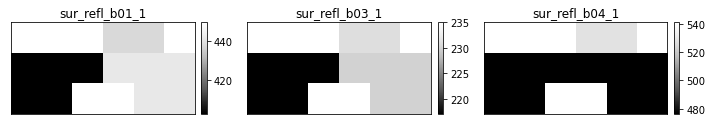

In [51]:
ep.plot_bands(modis_rgb_xr.values,
              scale=False,
              figsize=(10, 5),
              title=rgb_bands)
plt.show()

### RGB Image of MODIS Data Using EarthPy

Once you have your data cleaned up, you can plot an RGB image of your data 
to ensure that it looks correct!

[This lesson will help you remember what bands to use.](https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/intro-multispectral-data/)

In [ ]:
def clean_array_plot(xr_obj):
    """
    Take an  xarray object and replace null values with a mask for plotting

    Parameters
    ----------
    xr_obj : xarray object

    Returns
    -------
    A masked numpy array 

    """

    return 

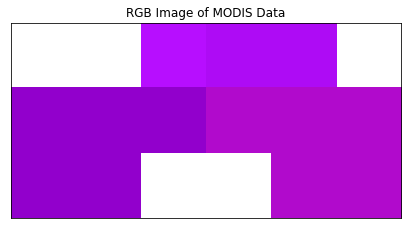

In [54]:
#modis_rgb_clean = clean_array_plot(modis_rgb_xr)

# Plot MODIS RGB image -Note that this looks weird only because
# the  data  are clipped to such  a "small" extent
ep.plot_rgb(modis_rgb_xr.values,
            rgb=[0, 1, 2],
            title='RGB Image of MODIS Data',
            figsize=(7, 7))

plt.show()

In [60]:
modis_rgb_unclipped = modis_bands_not_clipped[rgb_bands].to_array().squeeze()
modis_rgb_unclipped

<xarray.DataArray (variable: 3, y: 2400, x: 2400)>
array([[[1902., 1949., 1947., ..., 1327., 1327., 1181.],
        [1949., 2160., 2095., ..., 1327., 1273., 1273.],
        [2054., 2156., 2187., ..., 1139., 1101., 1206.],
        ...,
        [1387., 1469., 1469., ...,  343.,  499., 1006.],
        [1298., 1316., 1469., ...,  905.,  499.,  436.],
        [1316., 1316., 1454., ...,  905.,  578.,  351.]],

       [[1056., 1072., 1012., ...,  745.,  745.,  581.],
        [1051., 1150., 1039., ...,  745.,  595.,  595.],
        [1073., 1220., 1152., ...,  588.,  564.,  563.],
        ...,
        [ 759.,  813.,  813., ...,  150.,  218.,  852.],
        [ 703.,  735.,  813., ...,  585.,  218.,  199.],
        [ 735.,  735.,  798., ...,  585.,  338.,  109.]],

       [[1534., 1567., 1527., ..., 1107., 1107., 1069.],
        [1548., 1776., 1665., ..., 1107., 1121., 1121.],
        [1696., 1813., 1820., ..., 1029., 1018., 1077.],
        ...,
        [1209., 1267., 1267., ...,  597.,  788., 1153.],
        [1165., 1154., 1267., ..., 1089.,  788.,  603.],
        [1154., 1154., 1231., ..., 1089.,  759.,  516.]]], dtype=float32)
Coordinates:
  * y            (y) float64 4.448e+06 4.447e+06 ... 3.337e+06 3.336e+06
  * x            (x) float64 -1.001e+07 -1.001e+07 ... -8.896e+06 -8.896e+06
    band         int64 1
    spatial_ref  int64 0
  * variable     (variable) <U14 'sur_refl_b01_1' ... 'sur_refl_b04_1'
Attributes: (12/136)
    ADDITIONALLAYERS1KM:                 11
    ADDITIONALLAYERS500M:                1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   2705510
    total_additional_observations_500m:  660129
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

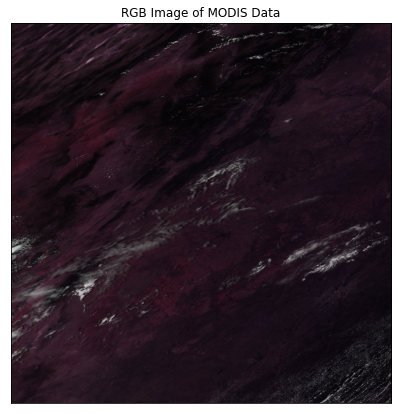

In [62]:
# Plot unclipped data - RGB (just a demo)
#modis_rgb_clean_not_clipped = clean_array_plot(modis_rgb_unclipped)

# Plot MODIS RGB image -Note that this looks weird only because
# the data are clipped to such a "small" extent
ep.plot_rgb(modis_rgb_unclipped,
            rgb=[0, 1, 2],
            title='RGB Image of MODIS Data',
            figsize=(7, 7))

plt.show()

##  Function  To  Open  and Clean  MODIS Data
Above we walked through the specific workflow for using MODIS data.
You can however use the same function that you used last week 
to process Landsat and NAIP data for MODIS.

The difference is now you  an  add the v ariable  parameter
to include the list of bands that you wish to grab from the
data.

In [ ]:
# Function in your homework assignment
def open_clean_bands(band_path,
                     crop_bound,
                     valid_range=None,
                     variable=None):
    """Open and clean a single landsat band.

    Parameters
    -----------
    band_path : string 
        A path to the array to be opened.
    crop_bound : geopandas GeoDataFrame
        A geopandas dataframe to be used to crop the raster data using rioxarray clip().
    valid_range:tuple (optional)
        A tuple of min and max range of values for the data. Default = None.
    variable : List
        A list of variables to be opened from the raster.

    Returns
    -----------
    band : xarray DataArray
        Cropped xarray DataArray

    """

    crop_bound_box = [box(*crop_bound.bounds.loc[0])]

    driver = get_dataset_driver(band_path)

    if :
        raise ValueError("OOPS I've encountered an HDF file  "
                         "which may have subgroups, please be sure  "
                         "to specify the variable=parameter so "
                         "I can clip the data properly.")

    try:
        band = (rxr.open_rasterio(
                    band_path,
                    masked=True,
                    variable=variable)
                .rio.clip(
                    crop_bound_box,
                    crs=crop_bound.crs,
                    all_touched=True,
                    from_disk=True)
                .squeeze())
    except:
        raise ValueError("Oops - I couldn't clip your data. "
                         "This may be due to a crs error.")

    # Mask the data to the valid range if a valid range tuple is provided
    if valid_range is not None:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    return band

In [ ]:
# # If you dont specify variables, this function will fail to clip the data
try:
    open_clean_bands(modis_pre_path,
                     crop_bound=fire_boundary)
except Exception as exception:
    print(exception)

Below, we use the bands object to subset the data. 

In [ ]:
cleaned_MODIS_data = open_clean_bands(modis_pre_path,
                                      crop_bound=fire_boundary,
                                      variable=desired_bands)
cleaned_MODIS_data

Note - it's ok if the plot below looks funky.
It represents very few pixels and pre-fire data does
not have a lot of variation in the pixels.

In [ ]:
# Plot unclipped data - RGB
modis_rgb = cleaned_MODIS_data[rgb_bands].to_array().squeeze()
modis_rgb_plot = clean_array_plot(modis_rgb)

# Plot MODIS RGB image - Note that this looks pixellated
# The data are clipped to a very "small" extent relative to the resolution
ep.plot_rgb(modis_rgb_plot,
            rgb=[0, 1, 2],
            title='RGB Image of MODIS Data',
            figsize=(7, 7))

plt.show()

In [ ]:
ep.plot_bands(modis_rgb_plot)
plt.show()